<a href="https://colab.research.google.com/github/YoussefKh200/XAUUSD-AI-Model/blob/main/price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **XAUUSD Price prediction**

##**Load Data**

In [31]:
!pip install numpy pandas matplotlib torch scikit-learn


In [32]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [33]:
!pip install transformers

In [34]:
!pip install datasets
!pip install tokenizers


In [35]:
from datasets import load_dataset

ds = load_dataset("Caibaocb/xauusd-gold-price-historical-data-2004-2025")

# Prepare the Data

In [36]:
df = ds["train"].to_pandas()
df.head()

,Date,Open,High,Low,Close,Volume
0,2004.06.11 07:15,384.0,384.3,383.8,384.3,12
1,2004.06.11 07:30,383.8,384.3,383.6,383.8,12
2,2004.06.11 07:45,383.3,383.8,383.3,383.8,20
3,2004.06.11 08:00,383.8,384.1,383.6,383.6,8
4,2004.06.11 08:15,383.6,384.3,383.5,383.5,20


In [37]:
print(df.columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [46]:
import numpy as np
import pandas as pd

# --- Sort by time (critical)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# --- Returns
df["return"] = df["Close"].pct_change()

# --- Moving Averages
df["ma_10"]  = df["Close"].rolling(10).mean()
df["ma_50"]  = df["Close"].rolling(50).mean()
df["ma_200"] = df["Close"].rolling(200).mean()

# --- RSI (14)
delta = df["Close"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()

rs = avg_gain / avg_loss
df["rsi"] = 100 - (100 / (1 + rs))

# --- ATR (14)
high_low = df["High"] - df["Low"]
high_close = np.abs(df["High"] - df["Close"].shift())
low_close = np.abs(df["Low"] - df["Close"].shift())

tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df["atr"] = tr.rolling(14).mean()

# --- Trend regime (1 = bullish, 0 = bearish)
df["trend"] = (df["Close"] > df["ma_200"]).astype(int)

# --- Target: price up in NEXT 5 DAYS
df["future_close"] = df["Close"].shift(-5)
df["target"] = (df["future_close"] > df["Close"]).astype(int)

# --- Drop NaNs
df.dropna(inplace=True)

# --- Final features & labels
features = [
    "return", "ma_10", "ma_50",
    "rsi", "atr", "trend"
]

X = df[features].values
y = df["target"].values

print("X shape:", X.shape)
print("y mean :", y.mean())



X shape: (8885283, 6)
y mean : 0.45338071955614695


In [39]:
print(X.shape, y.shape)
print(np.unique(y, return_counts=True))

(8886951, 3) (8886951,)
(array([0, 1]), array([4717443, 4169508]))


# Train / Test split + scaling

In [47]:
from sklearn.preprocessing import StandardScaler

split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print(X_train.shape, X_test.shape)


(7108226, 6) (1777057, 6)


# Neural Network (unchanged, but verified)

In [48]:
import torch
import torch.nn as nn

class TradingNN(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

model = TradingNN(X_train.shape[1])


# Training loop

In [49]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(300):
    preds = model(X_train_t)
    loss = criterion(preds, y_train_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 0.6916
Epoch 50 | Loss: 0.6693
Epoch 100 | Loss: 0.6595
Epoch 150 | Loss: 0.6559
Epoch 200 | Loss: 0.6538
Epoch 250 | Loss: 0.6527


# Evaluation

In [50]:
model.eval()

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

with torch.no_grad():
    probs = model(X_test_t).view(-1)
    preds = (probs > 0.5).int()

accuracy = (preds == y_test_t).float().mean()
print("Test accuracy:", accuracy.item())


Test accuracy: 0.5824883580207825


# Simple Backtester

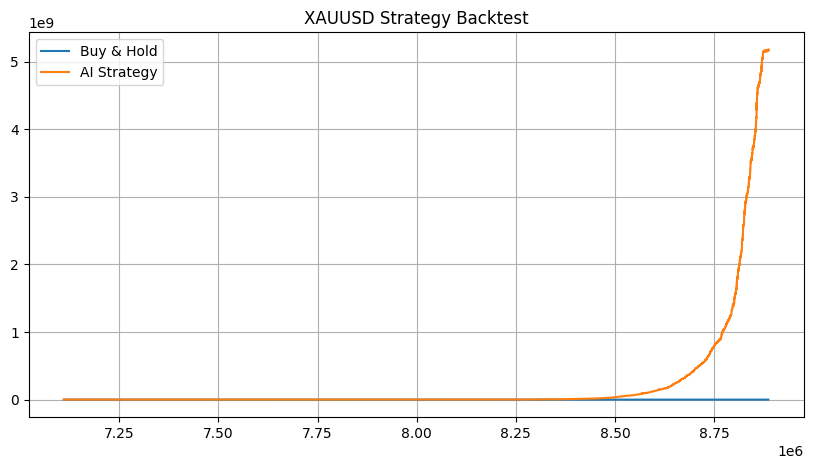

In [51]:
import matplotlib.pyplot as plt

# Align prices with test set
test_df = df.iloc[split:].copy()
test_df["prediction"] = preds.numpy()

# Strategy:
# Long if prediction = 1 AND trend = bullish
test_df["strategy"] = (
    (test_df["prediction"] == 1) &
    (test_df["trend"] == 1)
).astype(int)

# Daily returns
test_df["market_ret"] = test_df["Close"].pct_change()
test_df["strategy_ret"] = test_df["strategy"].shift(1) * test_df["market_ret"]

# Cumulative returns
test_df["cum_market"] = (1 + test_df["market_ret"]).cumprod()
test_df["cum_strategy"] = (1 + test_df["strategy_ret"]).cumprod()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(test_df["cum_market"], label="Buy & Hold")
plt.plot(test_df["cum_strategy"], label="AI Strategy")
plt.legend()
plt.title("XAUUSD Strategy Backtest")
plt.grid()
plt.show()


# Confusion Matrix

In [44]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds.numpy())
cm


array([[510195, 389504],
       [336936, 540756]])

# Sanity checks

In [45]:
print("y mean (train):", y_train.mean())
print("y mean (test): ", y_test.mean())



y mean (train): 0.4630126196276563
y mean (test):  0.49380918436067245
